<a href="https://colab.research.google.com/github/Tobias-2/FINALL-REPOSITORIES-FROM-COLAB/blob/main/19_2_Warstwy_konwolucyjne_w_praktyce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Czas wykorzystać poznaną wiedzę w praktyce. Nauczymy model rozróżniać koty i psy. Dla przypomnienia – dla sieci neuronowych dobrze korzystać z Google Colaba.

In [ ]:
import os
import shutil
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

Następnie pobieramy zbiór danych.

In [ ]:
!wget --no-check-certificate "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" -O "/tmp/cats-and-dogs.zip"

--2025-01-22 08:09:01--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.207.53.2, 2600:1408:9000:68a::317f, 2600:1408:9000:6ac::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.207.53.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   122MB/s    in 6.5s    

2025-01-22 08:09:07 (122 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [ ]:
def get_valid(file_path):
    correct_files = []
    for name in os.listdir(file_path):
        try:
            img = Image.open(file_path + "/" + name)
            correct_files.append(name)
        except UnidentifiedImageError:
            pass
    return correct_files

In [ ]:
local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
classes = ['Cat', 'Dog']
original_cat_path = '/tmp/PetImages/Cat'
original_dog_path = '/tmp/PetImages/Dog'
original_cat = get_valid(original_cat_path)
original_dog = get_valid(original_dog_path)
random.seed(101)

random.shuffle(original_cat)
random.shuffle(original_dog)
size = min(len(original_cat), len(original_dog))
train_size = int(np.floor(0.7 * size))

valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size
base_directory = 'dataset'
os.mkdir(base_directory)
type_datasets = ['train', 'valid', 'test']
directories = {}

for type_dataset in type_datasets:
    directory = os.path.join(base_directory, type_dataset)
    os.mkdir(directory)
    for name_class in classes:
        animal = os.path.join(directory, name_class)
        os.mkdir(animal)
        directories[f'{type_dataset}_{name_class}'] = animal+'/'
index = 0

for name_cat, name_dog in zip(original_cat, original_dog):
        if index <= train_size:
            type_of_dataset = 'train'
        elif train_size < index <= (train_size + valid_size):
            type_of_dataset = 'valid'
        elif (train_size + valid_size) < index <= (train_size + valid_size + test_size):
            type_of_dataset = 'test'
        shutil.copyfile(src=(original_cat_path + '/' +name_cat), dst=(directories[f'{type_of_dataset}_Cat']+name_cat))
        shutil.copyfile(src=(original_dog_path + '/' + name_dog), dst=(directories[f'{type_of_dataset}_Dog']+name_dog))
        index += 1

print(f'Dog - train: {len(os.listdir(directories["train_Dog"]))}\tCat - train: {len(os.listdir(directories["train_Cat"]))}')
print(f'Dog - valid: {len(os.listdir(directories["valid_Dog"]))}\tCat - valid: {len(os.listdir(directories["valid_Cat"]))}')
print(f'Dog - test:  {len(os.listdir(directories["test_Dog"]))}\tCat - test:  {len(os.listdir(directories["test_Cat"]))}')

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Dog - train: 8750	Cat - train: 8750
Dog - valid: 2499	Cat - valid: 2499
Dog - test:  1250	Cat - test:  1250


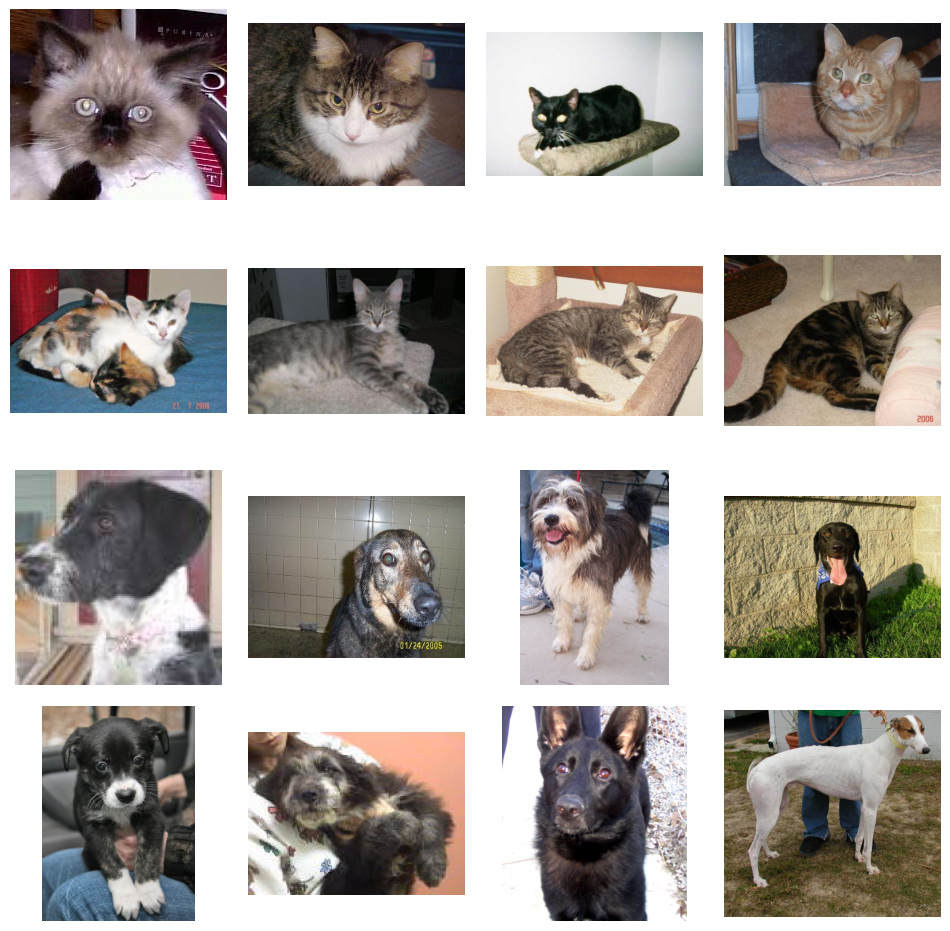

In [ ]:
fig = plt.figure(figsize = (12, 12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for i, element in enumerate(os.listdir(os.path.join(directories["train_Cat"]))[:8]):
    ax = fig.add_subplot(4, 4, i+1)
    img = Image.open(directories["train_Cat"]+element)
    ax.imshow(img)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

for i, element in enumerate(os.listdir(os.path.join(directories["train_Dog"]))[:8]):
    ax = fig.add_subplot(4, 4, i+9)
    img = Image.open(directories["train_Dog"]+element)
    ax.imshow(img)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [ ]:
img_width, img_height = 150, 150
train_data_dir = 'dataset/train/'
validation_data_dir = 'dataset/valid/'
epochs = 1000
batch_size = 64
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size
patience = 5
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size, class_mode='binary')
train_datagen_augmentation = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=30,
                                   horizontal_flip=True)
train_generator_augmentation = train_datagen_augmentation.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size, class_mode='binary')

Found 17500 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.
Found 17500 images belonging to 2 classes.


In [ ]:
models = []
os.mkdir("history")
os.mkdir("charts")

In [ ]:
model_baseline = Sequential()
model_baseline.add(Flatten(input_shape=(150, 150, 3)))
model_baseline.add(Dense(units=1, activation='sigmoid'))
model_baseline.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_baseline.summary()
models.append("baseline")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 67500)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          67,501 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,501 (263.68 KB)

 Trainable params: 67,501 (263.68 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
es = EarlyStopping(patience=patience, monitor='val_accuracy', restore_best_weights=True)

In [ ]:
history_baseline = model_baseline.fit(train_generator,
                                      steps_per_epoch=steps_per_epoch,
                                      epochs=epochs,
                                      validation_data=validation_generator,
                                      validation_steps=validation_steps,
                                      callbacks=[es])
history_baseline_df = pd.DataFrame(history_baseline.history)
history_baseline_csv_file = 'history/history_baseline.csv'

with open(history_baseline_csv_file, mode='w') as f:
    history_baseline_df.to_csv(f)

Epoch 1/1000


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.5017 - loss: 1.1164

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


136/136 ━━━━━━━━━━━━━━━━━━━━ 23s 155ms/step - accuracy: 0.5017 - loss: 1.1155 - val_accuracy: 0.5204 - val_loss: 0.8201
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.5228 - loss: 0.9092 - val_accuracy: 0.5625 - val_loss: 0.6876
Epoch 3/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - accuracy: 0.5704 - loss: 0.6884 - val_accuracy: 0.5000 - val_loss: 0.7383
Epoch 4/1000


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 156ms/step - accuracy: 0.5143 - loss: 0.9309 - val_accuracy: 0.5012 - val_loss: 1.0466
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - accuracy: 0.5361 - loss: 0.9032 - val_accuracy: 0.5317 - val_loss: 0.7839
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step - accuracy: 0.5236 - loss: 0.8208 - val_accuracy: 0.6667 - val_loss: 1.0935
Epoch 7/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 60s 144ms/step - accuracy: 0.5277 - loss: 0.9189 - val_accuracy: 0.5913 - val_loss: 0.6724
Epoch 8/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 0.5313 - loss: 0.9064 - val_accuracy: 0.5228 - val_loss: 0.9431
Epoch 9/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - accuracy: 0.5863 - loss: 0.6758 - val_accuracy: 0.5000 - val_loss: 0.6333
Epoch 10/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.5448 - loss: 0.8950 - val_accuracy: 0.5188 - val_loss: 1.0595
Epoch 11/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 23s 169ms/step - accuracy: 0.5410 - loss

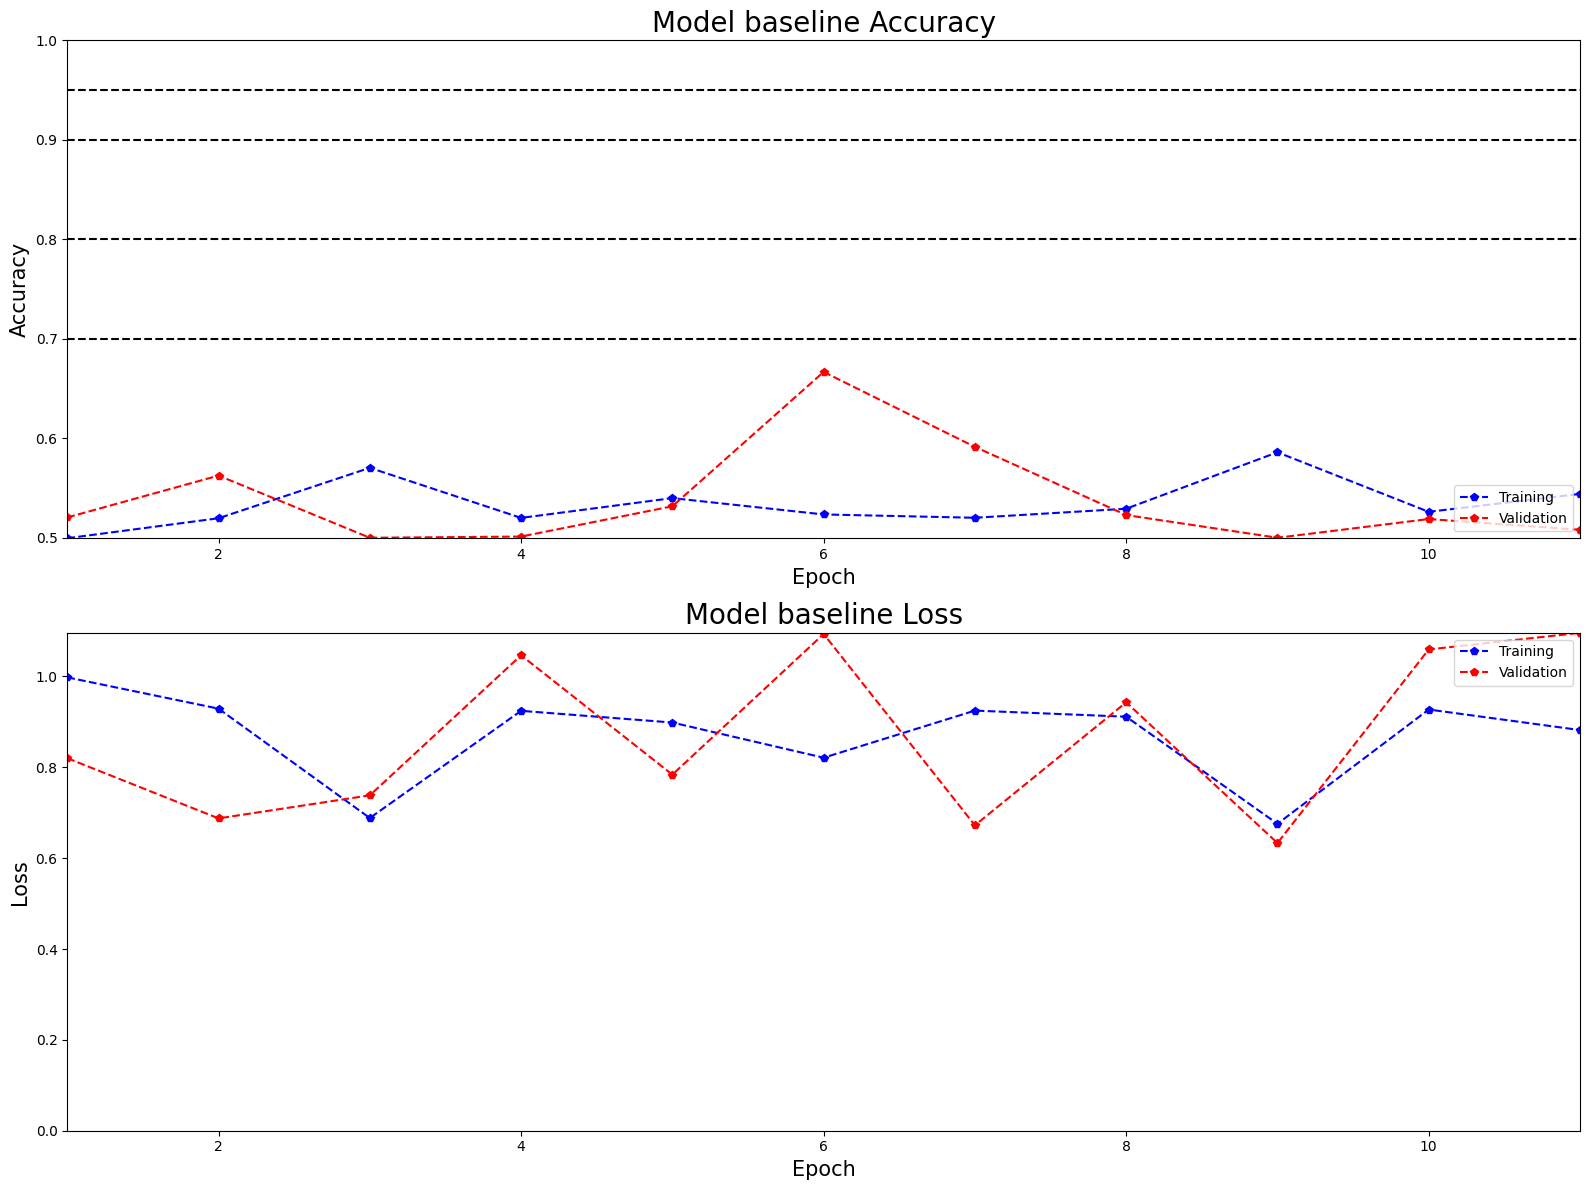

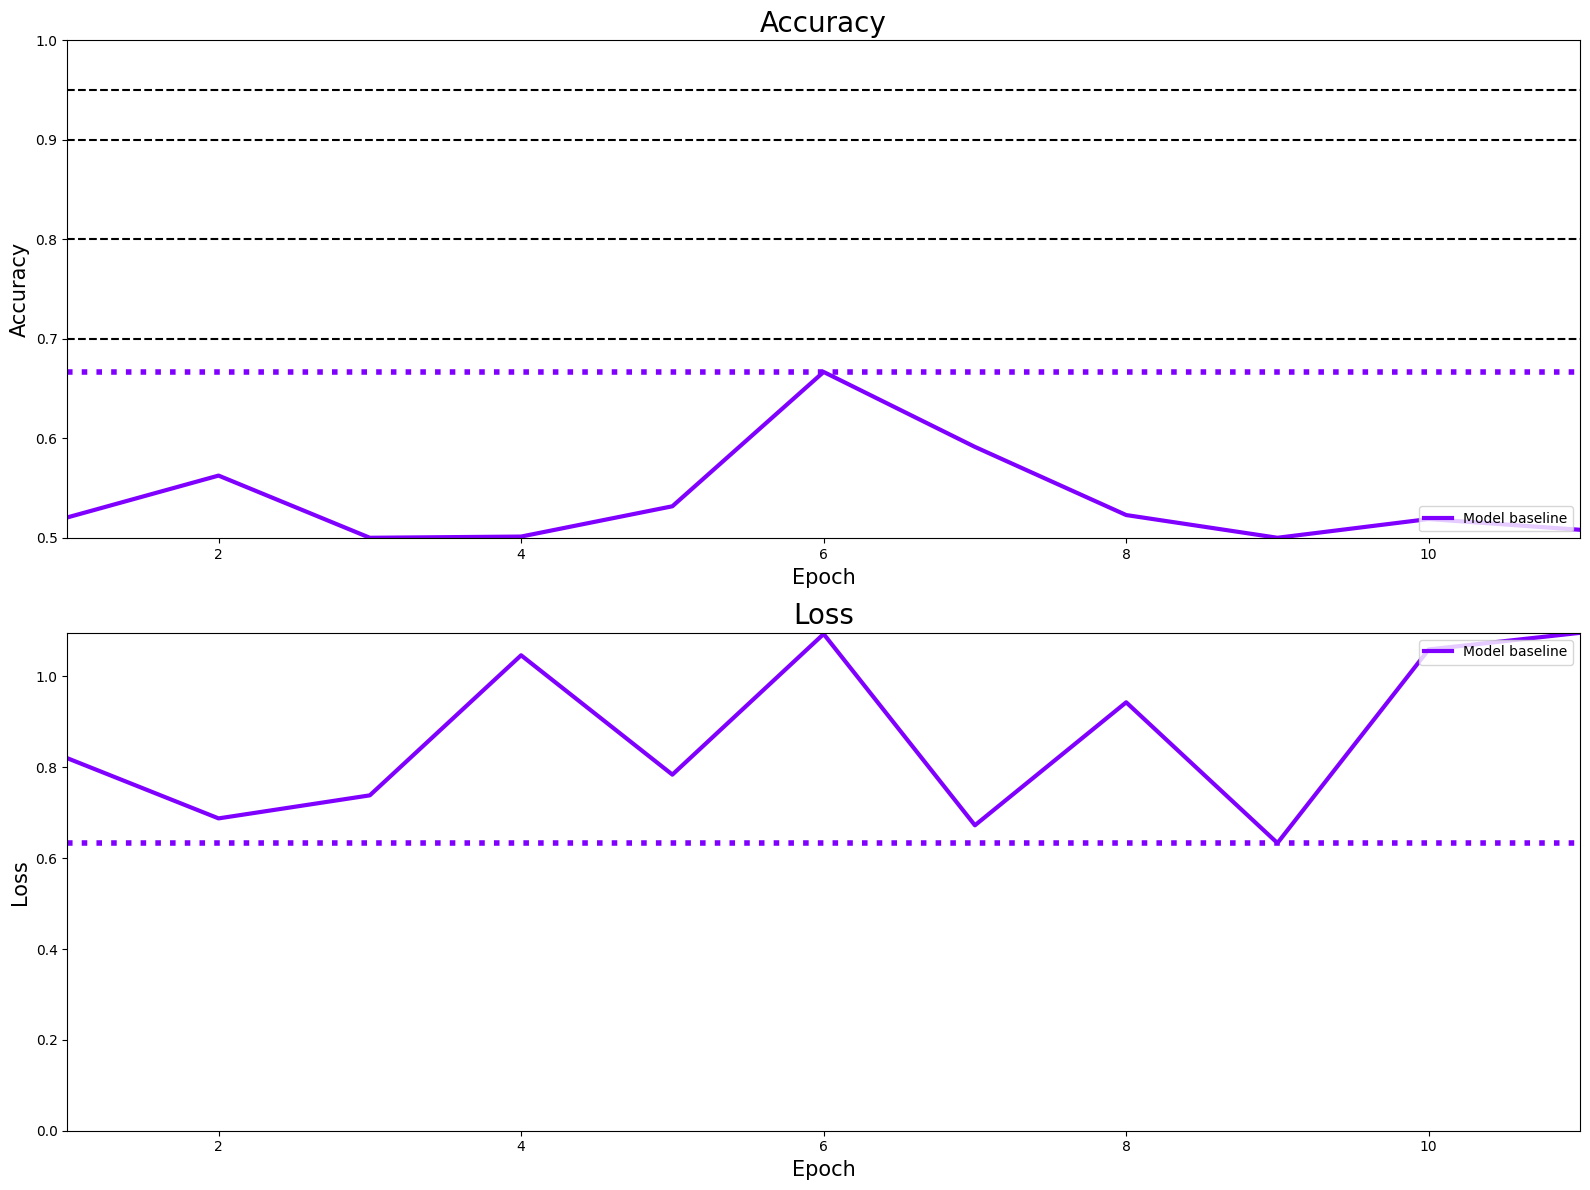

In [ ]:
max_index = 0
min_accuracy = 1
max_loss = 0
colors = plt.cm.rainbow(np.linspace(0, 1, len(models)))

for model in models:
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    if max_index < max(df.index):
        max_index = max(df.index)
    if min_accuracy > min(df[['accuracy', 'val_accuracy']].min()):
        min_accuracy = min(df[['accuracy', 'val_accuracy']].min())
    if max_loss < max(df[['loss', 'val_loss']].max()):
        max_loss = max(df[['loss', 'val_loss']].max())

for model in models:
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    fig = plt.figure(figsize=(16,12))
    ax = fig.add_subplot(211)
    ax.plot(df['accuracy'], "bp--")
    ax.plot(df['val_accuracy'], "rp--")
    ax.set_title(f'Model {model} Accuracy', fontsize=20)
    ax.set_ylabel('Accuracy', fontsize=15)
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_xlim([1, max_index])
    ax.set_ylim([min_accuracy, 1])

    for milestone in (0.7, 0.8, 0.9, 0.95):
        ax.axhline(milestone, color="k", linestyle="--")
        try:
            if min(df[df['val_accuracy'] >= milestone].index) > 1:
                plt.axvline(min(df[df['val_accuracy'] >= milestone].index), color="g", linestyle="--")
                ax.text(min(df[df['val_accuracy'] >= milestone].index)+0.6, min_accuracy+0.02,
                        f'Epoch: {min(df[df["val_accuracy"] >= milestone].index)}', rotation=90)
        except:
            pass

    plt.legend(['Training', 'Validation'], loc='lower right')
    ax = fig.add_subplot(212)
    ax.plot(df['loss'], "bp--")
    ax.plot(df['val_loss'], "rp--")
    ax.set_title(f'Model {model} Loss', fontsize=20)
    ax.set_ylabel('Loss', fontsize=15)
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_xlim([1, max_index])
    ax.set_ylim([0, max_loss])
    ax.legend(['Training', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.savefig(f'charts/train_history_{model}.png', transparent=True, dpi=600)
    plt.show()

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(211)
for model, color in zip(models, colors):
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    ax.plot(df['val_accuracy'], label=f'Model {model}', color=color, linewidth=3)
    ax.axhline(df['val_accuracy'].max(), color=color, linestyle="dotted", linewidth=4)

ax.set_title(f'Accuracy', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([min_accuracy, 1])
for milestone in (0.7, 0.8, 0.9, 0.95):
    ax.axhline(milestone, color="k", linestyle="--")
plt.legend(loc='lower right')
ax = fig.add_subplot(212)
for model, color in zip(models, colors):
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    ax.plot(df['val_loss'], label=f'Model {model}', color=color, linewidth=3)
    ax.axhline(df['val_loss'].min(), color=color, linestyle="dotted", linewidth=4)
ax.set_title(f'Loss', fontsize=20)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([0, max_loss])
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f'charts/train_history_of_each_model.png', transparent=True, dpi=600)
plt.show()

Model podstawowy 1

In [ ]:
model_simple_1 = Sequential()
model_simple_1.add(Conv2D(filters=10, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model_simple_1.add(MaxPooling2D(2, 2))
model_simple_1.add(Flatten())
model_simple_1.add(Dense(units=1, activation='sigmoid'))
model_simple_1.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])
model_simple_1.summary()
models.append("simple_1")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 54760)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          54,761 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,041 (215.00 KB)

 Trainable params: 55,041 (215.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_simple_1 = model_simple_1.fit(train_generator, # Replace fit_generator with fit
                                                steps_per_epoch=steps_per_epoch,
                                                epochs=epochs,
                                                validation_data=validation_generator,
                                                validation_steps=validation_steps,
                                                callbacks=[es])

history_simple_1_df = pd.DataFrame(history_simple_1.history)
history_simple_1_csv_file = 'history/history_simple_1.csv'

with open(history_simple_1_csv_file, mode='w') as f:
    history_simple_1_df.to_csv(f)

Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 94s 671ms/step - accuracy: 0.5520 - loss: 0.8927 - val_accuracy: 0.6442 - val_loss: 0.6242
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 91s 667ms/step - accuracy: 0.6731 - loss: 0.5924 - val_accuracy: 0.6755 - val_loss: 0.5986
Epoch 3/1000
  2/136 ━━━━━━━━━━━━━━━━━━━━ 1:46 792ms/step - accuracy: 0.6133 - loss: 0.5669

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


136/136 ━━━━━━━━━━━━━━━━━━━━ 40s 288ms/step - accuracy: 0.5863 - loss: 0.5980 - val_accuracy: 0.8333 - val_loss: 0.6753
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 92s 668ms/step - accuracy: 0.7345 - loss: 0.5350 - val_accuracy: 0.6983 - val_loss: 0.5699
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 93s 687ms/step - accuracy: 0.7721 - loss: 0.4855 - val_accuracy: 0.7163 - val_loss: 0.5639
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7891 - loss: 0.4920 - val_accuracy: 0.6667 - val_loss: 0.9340
Epoch 7/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 92s 674ms/step - accuracy: 0.7887 - loss: 0.4649 - val_accuracy: 0.7103 - val_loss: 0.5659
Epoch 8/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 92s 674ms/step - accuracy: 0.7982 - loss: 0.4468 - val_accuracy: 0.7196 - val_loss: 0.5616


Model podstawowy 2

In [ ]:
model_simple_2 = Sequential()
model_simple_2.add(Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)))
model_simple_2.add(MaxPooling2D(2, 2))
model_simple_2.add(Flatten())
model_simple_2.add(Dense(units=1, activation='sigmoid'))
model_simple_2.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])
model_simple_2.summary()
models.append("simple_2")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 150, 150, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 75, 75, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 56250)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │          56,251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,531 (220.82 KB)

 Trainable params: 56,531 (220.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_1 = Sequential()

# Block 1
model_1.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_1.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model_1.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Flatten())
model_1.add(Dense(256, activation='relu'))
model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(units=1, activation='sigmoid'))
model_1.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4), # Changed 'lr' to 'learning_rate'
                       metrics=['accuracy'])
model_1.summary()
models.append("model_1")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 150, 150, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 150, 150, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 75, 75, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 37, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       2,654,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,981,009 (11.37 MB)

 Trainable params: 2,981,009 (11.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_2 = Sequential()

# Block 1
model_2.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_2.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model_2.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Flatten())
model_2.add(Dropout(0.5))
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(units=1, activation='sigmoid'))
model_2.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_2.summary()
models.append("model_2")

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)                   │ (None, 150, 150, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 150, 150, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 75, 75, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 37, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │       2,654,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,981,009 (11.37 MB)

 Trainable params: 2,981,009 (11.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_3 = Sequential()

# Block 1
model_3.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_3.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model_3.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Flatten())
model_3.add(Dropout(0.5))
model_3.add(Dense(256, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(128, activation='relu'))
model_3.add(Dense(units=1, activation='sigmoid'))
model_3.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_3.summary()
models.append("model_3")

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)                   │ (None, 150, 150, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 150, 150, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 75, 75, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 37, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │       2,654,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,981,009 (11.37 MB)

 Trainable params: 2,981,009 (11.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_model_3 = model_3.fit(train_generator_augmentation, # Replace fit_generator with fit
                                        steps_per_epoch=steps_per_epoch,
                                        epochs=epochs,
                                        validation_data=validation_generator,
                                        validation_steps=validation_steps,
                                        callbacks=[es])

history_model_3_df = pd.DataFrame(history_model_3.history)
history_model_3_csv_file = 'history/history_model_3.csv'
with open(history_model_3_csv_file, mode='w') as f:
    history_model_3_df.to_csv(f)

Epoch 1/1000


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


136/136 ━━━━━━━━━━━━━━━━━━━━ 651s 5s/step - accuracy: 0.5105 - loss: 0.6938 - val_accuracy: 0.5032 - val_loss: 0.6920
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 652s 5s/step - accuracy: 0.5264 - loss: 0.6915 - val_accuracy: 0.5529 - val_loss: 0.6896
Epoch 3/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5624 - loss: 0.6870 - val_accuracy: 0.6667 - val_loss: 0.6665
Epoch 4/1000


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5345 - loss: 0.6903

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


136/136 ━━━━━━━━━━━━━━━━━━━━ 682s 5s/step - accuracy: 0.5346 - loss: 0.6903 - val_accuracy: 0.5962 - val_loss: 0.6795
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 630s 5s/step - accuracy: 0.5738 - loss: 0.6791 - val_accuracy: 0.6655 - val_loss: 0.6427


In [ ]:
from tensorflow.keras.applications import VGG16

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
vgg16.trainable = True

set_trainable = False
for layer in vgg16.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in vgg16.layers:
    print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

model_4 = Sequential()
model_4.add(vgg16)
model_4.add(Flatten())
model_4.add(Dropout(0.5))
model_4.add(Dense(256, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(128, activation='relu'))
model_4.add(Dense(units=1, activation='sigmoid'))
model_4.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_4.summary()
models.append("model_4")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
layer_name: input_layer_9 trainable: False
layer_name: block1_conv1  trainable: False
layer_name: block1_conv2  trainable: False
layer_name: block1_pool   trainable: False
layer_name: block2_conv1  trainable: False
layer_name: block2_conv2  trainable: False
layer_name: block2_pool   trainable: False
layer_name: block3_conv1  trainable: False
layer_name: block3_conv2  trainable: False
layer_name: block3_conv3  trainable: False
layer_name: block3_pool   trainable: False
layer_name: block4_conv1  trainable: False
layer_name: block4_conv2  trainable: False
layer_name: block4_conv3  trainable: False
layer_name: block4_pool   trainable: False
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_pool   trainable: True


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,845,121 (64.26 MB)

 Trainable params: 9,209,857 (35.13 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

# Zadanie: regularyzacja

Na podstawie wykorzystanych danych wytrenuj nowe modele z dodatkowymi warstwami (dodaj kolejne warstwy splotowe). Dla nowych sieci przetestuj ponownie wykorzystane techniki regularyzacji.

In [ ]:
history_model_4 = model_4.fit(train_generator_augmentation,
                                        steps_per_epoch=steps_per_epoch,
                                        epochs=epochs,
                                        validation_data=validation_generator,
                                        validation_steps=validation_steps,
                                        callbacks=[es])

history_model_4_df = pd.DataFrame(history_model_4.history)
history_model_4_csv_file = 'history/history_model_4.csv'
with open(history_model_4_csv_file, mode='w') as f:
    history_model_4_df.to_csv(f)

Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 3012s 22s/step - accuracy: 0.7252 - loss: 0.5358 - val_accuracy: 0.8978 - val_loss: 0.2420
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 2968s 22s/step - accuracy: 0.8795 - loss: 0.2850 - val_accuracy: 0.9255 - val_loss: 0.1674
Epoch 3/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 36s 147ms/step - accuracy: 0.9296 - loss: 0.1843 - val_accuracy: 0.8333 - val_loss: 0.2448
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 2991s 22s/step - accuracy: 0.9153 - loss: 0.2141 - val_accuracy: 0.9395 - val_loss: 0.1515
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 2985s 22s/step - accuracy: 0.9188 - loss: 0.2060 - val_accuracy: 0.9135 - val_loss: 0.2070
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 37s 145ms/step - accuracy: 0.9531 - loss: 0.1569 - val_accuracy: 1.0000 - val_loss: 0.0099
Epoch 7/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 2982s 22s/step - accuracy: 0.9330 - loss: 0.1773 - val_accuracy: 0.9459 - val_loss: 0.1296
Epoch 8/1000
 15/136 ━━━━━━━━━━━━━━━━━━━━ 35:38 18s/step - accuracy: 

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from keras.regularizers import l2

In [ ]:
model_5 = Sequential()


model_5.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3), kernel_regularizer=l2(0.01)))
model_5.add(MaxPooling2D((2, 2)))


model_5.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_5.add(MaxPooling2D((2, 2)))


model_5.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_5.add(MaxPooling2D((2, 2)))
model_5.add(Flatten())
model_5.add(Dropout(0.5))
model_5.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model_5.add(Dense(1, activation='sigmoid'))



model_5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



models.append("model_5")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
es = EarlyStopping(patience=patience, monitor='val_accuracy', restore_best_weights=True)

history_model_5 = model_5.fit(train_generator_augmentation,
                                        steps_per_epoch=steps_per_epoch,
                                        epochs=epochs,
                                        validation_data=validation_generator,
                                        validation_steps=validation_steps,
                                        callbacks=[es])

history_model_5_df = pd.DataFrame(history_model_5.history)
history_model_5_csv_file = 'history/history_model_5.csv'
with open(history_model_5_csv_file, mode='w') as f:
    history_model_5_df.to_csv(f)

Epoch 1/1000


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 55/136 ━━━━━━━━━━━━━━━━━━━━ 4:50 4s/step - accuracy: 0.4978 - loss: 2.5701

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


136/136 ━━━━━━━━━━━━━━━━━━━━ 531s 4s/step - accuracy: 0.5006 - loss: 1.8772 - val_accuracy: 0.4944 - val_loss: 0.7935
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 520s 4s/step - accuracy: 0.5053 - loss: 0.7708 - val_accuracy: 0.4932 - val_loss: 0.7280
Epoch 3/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.6170 - loss: 0.7251 - val_accuracy: 0.6667 - val_loss: 0.7232
Epoch 4/1000


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


136/136 ━━━━━━━━━━━━━━━━━━━━ 569s 4s/step - accuracy: 0.5001 - loss: 0.7207 - val_accuracy: 0.4896 - val_loss: 0.7072
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 511s 4s/step - accuracy: 0.4977 - loss: 0.7046 - val_accuracy: 0.4932 - val_loss: 0.6993
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.5156 - loss: 0.6990 - val_accuracy: 0.6667 - val_loss: 0.6968
Epoch 7/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 518s 4s/step - accuracy: 0.5064 - loss: 0.6981 - val_accuracy: 0.4936 - val_loss: 0.6961
Epoch 8/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 510s 4s/step - accuracy: 0.4960 - loss: 0.6956 - val_accuracy: 0.5012 - val_loss: 0.6946


In [ ]:
es = EarlyStopping(patience=patience, monitor='val_accuracy', restore_best_weights=True)

In [ ]:
model_6 = Sequential()

# Block 1
model_6.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3), kernel_regularizer=l2(0.01)))
model_6.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_6.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_6.add(MaxPooling2D((2, 2)))

# Block 2
model_6.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_6.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_6.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_6.add(MaxPooling2D((2, 2)))

# Block 3
model_6.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_6.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_6.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_6.add(MaxPooling2D((2, 2)))

model_6.add(Flatten())
model_6.add(Dropout(0.5))
model_6.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model_6.add(Dense(1, activation='sigmoid'))

model_6.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

models.append("model_6")

history_model_6 = model_6.fit(train_generator_augmentation,
                                        steps_per_epoch=steps_per_epoch,
                                        epochs=epochs,
                                        validation_data=validation_generator,
                                        validation_steps=validation_steps,
                                        callbacks=[es])

history_model_6_df = pd.DataFrame(history_model_6.history)
history_model_6_csv_file = 'history/history_model_6.csv'
with open(history_model_6_csv_file, mode='w') as f:
    history_model_6_df.to_csv(f)

Epoch 1/1000


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


136/136 ━━━━━━━━━━━━━━━━━━━━ 1859s 14s/step - accuracy: 0.5063 - loss: 2.9403 - val_accuracy: 0.4948 - val_loss: 0.6968
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 1786s 13s/step - accuracy: 0.5049 - loss: 0.6946 - val_accuracy: 0.5028 - val_loss: 0.6931
Epoch 3/1000
  2/136 ━━━━━━━━━━━━━━━━━━━━ 24:27 11s/step - accuracy: 0.4922 - loss: 0.6933

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


136/136 ━━━━━━━━━━━━━━━━━━━━ 23s 86ms/step - accuracy: 0.4845 - loss: 0.6934 - val_accuracy: 0.6667 - val_loss: 0.6912
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 1803s 13s/step - accuracy: 0.5009 - loss: 0.6932 - val_accuracy: 0.4900 - val_loss: 0.6934
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 1760s 13s/step - accuracy: 0.4939 - loss: 0.6933 - val_accuracy: 0.5088 - val_loss: 0.6930
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 46s 255ms/step - accuracy: 0.4375 - loss: 0.6942 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 1766s 13s/step - accuracy: 0.4948 - loss: 0.6932 - val_accuracy: 0.4988 - val_loss: 0.6932
Epoch 8/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 1749s 13s/step - accuracy: 0.4834 - loss: 0.6932 - val_accuracy: 0.5104 - val_loss: 0.6931


In [ ]:
model_7 = Sequential()

# Block 1
model_7.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_7.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_7.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_7.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_7.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_7.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_7.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_7.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_7.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model_7.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_7.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_7.add(MaxPooling2D(pool_size=(2, 2)))
model_7.add(Flatten())
model_7.add(Dropout(0.5))
model_7.add(Dense(256, activation='relu'))
model_7.add(Dropout(0.5))
model_7.add(Dense(128, activation='relu'))
model_7.add(Dense(units=1, activation='sigmoid'))
model_7.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_7.summary()
models.append("model_7")

history_model_7 = model_7.fit(train_generator_augmentation,
                                        steps_per_epoch=steps_per_epoch,
                                        epochs=epochs,
                                        validation_data=validation_generator,
                                        validation_steps=validation_steps,
                                        callbacks=[es])

history_model_7_df = pd.DataFrame(history_model_6.history)
history_model_7_csv_file = 'history/history_model_6.csv'
with open(history_model_7_csv_file, mode='w') as f:
    history_model_7_df.to_csv(f)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 150, 150, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 150, 150, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 75, 75, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 37, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       2,654,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,981,009 (11.37 MB)

 Trainable params: 2,981,009 (11.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
 68/136 ━━━━━━━━━━━━━━━━━━━━ 5:26 5s/step - accuracy: 0.5183 - loss: 0.6930

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


136/136 ━━━━━━━━━━━━━━━━━━━━ 717s 5s/step - accuracy: 0.5136 - loss: 0.6929 - val_accuracy: 0.5128 - val_loss: 0.6920
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 706s 5s/step - accuracy: 0.5228 - loss: 0.6916 - val_accuracy: 0.5072 - val_loss: 0.6924
Epoch 3/1000
  2/136 ━━━━━━━━━━━━━━━━━━━━ 11:12 5s/step - accuracy: 0.5234 - loss: 0.6885

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


136/136 ━━━━━━━━━━━━━━━━━━━━ 42s 285ms/step - accuracy: 0.5157 - loss: 0.6899 - val_accuracy: 0.1667 - val_loss: 0.7164
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 773s 5s/step - accuracy: 0.5487 - loss: 0.6871 - val_accuracy: 0.5296 - val_loss: 0.6832
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 704s 5s/step - accuracy: 0.5923 - loss: 0.6709 - val_accuracy: 0.6214 - val_loss: 0.6452
